In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 10 - Modified CNN with Fibonacci

### v4 The Model Beta

by Louis Yang

Use Fibonacci series median as the center of each data.

According to the center, split data into groups and train individual neural network (model) in each group.

The grouping split are log10(fib_med + 1) < (1.0 , 2.0, 4.0, rest) There are total 4 groups.

The first 1 groups use original Fibonacci median as prediction since it is difficult to learn. The rest groups use the trained CNN as prediction.

The neural network structure is: 

    1 Conv1D(120) with filter size 3 > Average pooling(2) > FC(120) > FC(120) > FC(63, linear).

Then do ensemble learning: Evaluate the same model 5 times and take the ensemble median.

v0 Feed second input (median and stdev) to the neural network after the CNN part.

Test on stage 1 data.

Original model: 'model_10_Modified_CNN_0_median_stdev'

In [2]:
model_name = 'model_10_Modified_CNN_4_The_Model_1_stage_1_train'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [4]:
train_file = 'train_1.csv'

In [5]:
input_df = pd.read_csv('../data/' + train_file, nrows=1)

In [6]:
input_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,32,63,15,26,14,20,22,19,18,20


In [7]:
input_df_dates = input_df.columns[1:]; input_df_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=550)

In [8]:
visits_dtype = {d: np.float32 for d in input_df_dates}

In [9]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file, engine='c', dtype=visits_dtype)
print('done!')

%%% Reading data train_1.csv ... done!


In [10]:
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [11]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float32(550), object(1)
memory usage: 305.5+ MB


## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [12]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [13]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [14]:
#test_length = 0  # for predicting
test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [15]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [16]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2015-08-30', '2015-10-31')

In [17]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [18]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [19]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2016-08-28', '2016-10-29')

In [20]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [21]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Should be the same

#### Y

In [22]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [23]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2015-11-01', '2016-01-02')

In [24]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [25]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-12'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [26]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2016-10-30', '2016-12-31')

In [27]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [28]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(6, 6)

Should be the same

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [29]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [30]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
        '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
        ...
        '2015-10-22', '2015-10-23', '2015-10-24', '2015-10-25', '2015-10-26',
        '2015-10-27', '2015-10-28', '2015-10-29', '2015-10-30', '2015-10-31'],
       dtype='object', length=123),
 Index(['2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09', '2015-12-10',
        '2015-12-11', '2015-12-12', '2015-12-13', '2015-12-14', '2015-12-15',
        ...
        '2016-10-20', '2016-10-21', '2016-10-22', '2016-10-23', '2016-10-24',
        '2016-10-25', '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29'],
       dtype='object', length=329))

In [31]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(2, 6)

In [32]:
fib_output_data = input_df[fib_output_dates].values; #fib_output_data

In [33]:
fib_input_data = input_df[fib_input_dates].values; #fib_input_data

#### Fibonacci median in each window

In [34]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [35]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [36]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [37]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python3\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

fib_input_median

fib_output_median

In [38]:
del fib_output_data
del fib_input_data
del fib_output_median_list
del fib_input_median_list
gc.collect()

0

We will use this as the center and part of the result

In [39]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input and Output data

In [40]:
X_input_raw = input_df[X_input_dates].values
Y_input_raw = input_df[Y_input_dates].values
X_output_raw = input_df[X_output_dates].values
if test_length:
    Y_output_raw = input_df[Y_output_dates].values

##### Convert nan to number 0.

In [41]:
X_input_num = np.nan_to_num(X_input_raw)
Y_input_num = np.nan_to_num(Y_input_raw)
X_output_num = np.nan_to_num(X_output_raw)
if test_length:
    Y_output_num = np.nan_to_num(Y_output_raw)

## Transform Data

### Log

In [42]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [43]:
X_input_raw_log = log(X_input_raw)  # Contain nan
Y_input_raw_log = log(Y_input_raw)
X_output_raw_log = log(X_output_raw)
if test_length:
    Y_output_raw_log = log(Y_output_raw)

In [44]:
X_input_log = log(X_input_num)  # Do not contain nan
Y_input_log = log(Y_input_num)
X_output_log = log(X_output_num)
if test_length:
    Y_output_log = log(Y_output_num)

In [45]:
X_input_log

array([[ 1.        ,  1.04139268,  1.        , ...,  0.90309   ,
         1.        ,  1.04139268],
       [ 1.36172783,  1.07918119,  1.91381383, ...,  1.25527251,
         1.56820178,  1.14612806],
       [ 0.30103001,  0.60206002,  0.69897002, ...,  0.30103001,
         1.04139268,  0.77815127],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

Z_input_data_log = log(Z_input_data_num)

##### Check Log transformation

In [46]:
print(X_input_log.shape, Y_input_log.shape, X_output_log.shape)
if test_length: print(Y_output_log.shape)

(145063, 63) (145063, 63) (145063, 63)
(145063, 63)


In [47]:
arr_info((X_input_log, Y_input_log, X_output_log))
if test_length: arr_info([Y_output_log])

shape, min, max, median, stdev
(145063, 63) 0.0 7.33352 1.88081 1.13491
(145063, 63) 0.0 7.32973 1.94939 1.11236
(145063, 63) 0.0 7.52436 2.14613 1.01734
shape, min, max, median, stdev
(145063, 63) 0.0 7.45244 2.15836 1.00455


In [48]:
#Check inverse log transformation
X_input_log_tt = unlog(X_input_log)
X_input_log_tt_dif = X_input_log_tt - X_input_num
X_input_log_tt_dif.min(), X_input_log_tt_dif.max(), np.median(X_input_log_tt_dif), np.std(X_input_log_tt_dif)

(-12.0, 10.0, 0.0, 0.018811859)

In [49]:
X_output_log_tt = unlog(X_output_log)
X_output_log_tt_dif = X_output_log_tt - X_output_num
X_output_log_tt_dif.min(), X_output_log_tt_dif.max(), np.median(X_output_log_tt_dif), np.std(X_output_log_tt_dif)

(-16.0, 16.0, 0.0, 0.03017088)

In [50]:
Y_input_log_tt = unlog(Y_input_log)
Y_input_log_tt_dif = Y_input_log_tt - Y_input_num
Y_input_log_tt_dif.min(), Y_input_log_tt_dif.max(), np.median(Y_input_log_tt_dif), np.std(Y_input_log_tt_dif)

(-12.0, 10.0, 0.0, 0.019053582)

In [51]:
Y_output_log_tt = unlog(Y_output_log)
Y_output_log_tt_dif = Y_output_log_tt - Y_output_num
Y_output_log_tt_dif.min(), Y_output_log_tt_dif.max(), np.median(Y_output_log_tt_dif), np.std(Y_output_log_tt_dif)

(-12.0, 12.0, 0.0, 0.027352171)

In [52]:
del X_input_log_tt; del X_input_log_tt_dif
del X_output_log_tt; del X_output_log_tt_dif
del Y_input_log_tt; del Y_input_log_tt_dif
del Y_output_log_tt; del Y_output_log_tt_dif
gc.collect()

120

There is some error (~10) due to float32 when unlog (exp) it. However, for those cases, the original number is about 10^7 so the relative error is still very small.

### Normalization (Center and Scale)

#### Center

In [53]:
output_center = log(fib_output_median).reshape(-1,1) # Fib. median as the center
#input_center = log(fib_input_median).reshape(-1,1)
input_center = output_center  # using output_center instead

In [54]:
X_input_center = input_center
Y_input_center = input_center
X_output_center = output_center
Y_output_center = output_center

In [55]:
output_center.shape

(145063, 1)

In [56]:
input_center, output_center

(array([[ 1.27875364],
        [ 1.41912925],
        [ 0.69897002],
        ..., 
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]], dtype=float32), array([[ 1.27875364],
        [ 1.41912925],
        [ 0.69897002],
        ..., 
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]], dtype=float32))

plt.scatter(X_input_center.reshape(-1),Y_input_center.reshape(-1))
plt.show()

Z_input_center = np.median(Z_input_data_log, axis=-1).reshape(-1,1)

Z_input_center.shape

#Use Regular Median as the Center for X
#Choice 1: Not including nan
X_input_center = np.nan_to_num(np.nanmedian(X_input_log, axis=-1)).reshape(-1,1)
X_output_center = np.nan_to_num(np.nanmedian(X_output_log, axis=-1)).reshape(-1,1)

#Choice 2: Including nan
#X_input_center = np.median(np.nan_to_num(X_input_log), axis=-1).reshape(-1,1)
#X_output_center = np.median(np.nan_to_num(X_output_log), axis=-1).reshape(-1,1)

Y_input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_input_center  # remember sample-wised center

Y_output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_output_center  # remember sample-wised center

#### Choice of default scale

In [57]:
default_input_scale = np.nanmedian(np.nanstd(X_input_raw_log, axis=-1))  # Do not include nan
default_input_scale

c:\python3\lib\site-packages\numpy\lib\nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.17761327

In [58]:
default_output_scale = np.nanmedian(np.nanstd(X_output_raw_log, axis=-1))  # Do not include nan
default_output_scale

c:\python3\lib\site-packages\numpy\lib\nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.18506594

In [59]:
default_scale = np.mean([default_input_scale, default_output_scale]); default_scale

0.18133961

#### Scale

In [60]:
#Choice 1: Treat nan as 0
input_scale = np.std(X_input_log, axis=-1).reshape(-1,1)
output_scale = np.std(X_output_log, axis=-1).reshape(-1,1)

#Choice 2: Not including nan
#input_scale = np.nan_to_num(np.nanstd(X_input_raw_log, axis=-1)).reshape(-1,1)
#output_scale = np.nan_to_num(np.nanstd(X_output_raw_log, axis=-1)).reshape(-1,1)

input_scale[input_scale == 0.0] = default_scale  # Prevent divid by zero 
output_scale[output_scale == 0.0] = default_scale  # Prevent divid by zero 

In [61]:
X_input_scale = input_scale
Y_input_scale = input_scale
X_output_scale = output_scale
Y_output_scale = output_scale

In [62]:
input_scale

array([[ 0.22974399],
       [ 0.2368575 ],
       [ 0.27363315],
       ..., 
       [ 0.18133961],
       [ 0.18133961],
       [ 0.18133961]], dtype=float32)

In [63]:
output_scale

array([[ 0.19725497],
       [ 0.25052369],
       [ 0.21878366],
       ..., 
       [ 0.18133961],
       [ 0.18133961],
       [ 0.18133961]], dtype=float32)

Z_input_scale = np.std(Z_input_data_log, axis=-1).reshape(-1,1)
Z_input_scale[Z_input_scale == 0.0] = default_input_scale  # Prevent divid by zero
Z_input_scale  # remember sample-wised scale

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [64]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [65]:
# Normalize after nan->0
X_input = transform(X_input_log, X_input_center, X_input_scale)
X_output = transform(X_output_log, X_output_center, X_output_scale)
Y_input = transform(Y_input_log, Y_input_center, Y_input_scale)
if test_length:
    Y_output = transform(Y_output_log, Y_output_center, Y_output_scale)    

# Another choice: Normalize before nan->0
#X_input = np.nan_to_num(transform(X_input_raw_log, X_input_center, input_scale))
#X_output = np.nan_to_num(transform(X_output_raw_log, X_output_center, output_scale))
#Y_input = np.nan_to_num(transform(Y_input_raw_log, Y_input_center, input_scale))
#if test_length:
#    Y_output = np.nan_to_num(transform(Y_output_raw_log, Y_output_center, output_scale))

Note:

* If we take nan_to_num before transform, we make sure the nan got transformed into 0 but not the center.
* If we take nan_to_num after transform, nan trun into the center but not 0 of the original data.

examine(Y_input)

input_data_norm = transform(input_data_log, Y_input_center, input_scale)
output_data_norm = transform(output_data_log, Y_output_center, output_scale)

Z_input = transform(Z_input_data_log, Z_input_center, Z_input_scale)

##### Check median and stdev transformations

In [66]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(X_input)  # Check if there is any nan in the input_data

#Check inverse scale transformation
X_input_unnorm = untransform(X_input, X_input_center, X_input_scale)
X_input_unnorm_dif = X_input_unnorm - X_input_log
X_input_unnorm_dif.min(), X_input_unnorm_dif.max()

#Check inverse scale transformation
Y_input_unnorm = untransform(Y_input, Y_input_center, Y_input_scale)
Y_input_unnorm_dif = Y_input_unnorm - Y_input_log
Y_input_unnorm_dif.min(), Y_input_unnorm_dif.max()

#Check inverse scale transformation
X_output_unnorm = untransform(X_output, X_output_center, X_output_scale)
X_output_unnorm_dif = X_output_unnorm - X_output_log
X_output_unnorm_dif.min(), X_output_unnorm_dif.max()

#Check inverse scale transformation
Y_output_unnorm = untransform(Y_output, Y_output_center, Y_output_scale)
Y_output_unnorm_dif = Y_output_unnorm - Y_output_log
Y_output_unnorm_dif.min(), Y_output_unnorm_dif.max()

del X_input_unnorm; del X_input_unnorm_dif
del Y_input_unnorm; del Y_input_unnorm_dif
del X_output_unnorm; del X_output_unnorm_dif
del Y_output_unnorm; del Y_output_unnorm_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

plt.hist(Y_input_center, bins=40, alpha=0.5, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.5, label='output')
plt.hist(X_input_center, bins=40, alpha=0.5, label='input')
plt.hist(X_output_center, bins=40, alpha=0.5, label='output')
#plt.hist(Z_input_center, bins=40, alpha=0.5, label='Z_input')
plt.legend()
plt.show()

plt.hist(Y_input_center, bins=40, alpha=0.7, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
#plt.hist(Z_input_scale, bins=40, alpha=0.7, label='Z_input')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [67]:
def group_index(logx):
    if logx < 1.0: return 0
    elif logx < 2.0: return 1
    elif logx < 4.0: return 2
    else: return 3
group_index_v = np.vectorize(group_index)
gp_list = list(range(4)); gp_list

[0, 1, 2, 3]

def group_index(median, stdev):
    if median < 1.0: return 0
    elif median < 2.0: 
        if stdev < 1.7: return 1
        else: return 2
    elif median < 4.0: 
        if stdev < 1.7: return 3
        else: return 4
    else: return 5
#group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

input_gp = np.array([group_index(center, scale) for center, scale in zip(Y_input_center, input_scale)]).reshape(-1)
output_gp = np.array([group_index(center, scale) for center, scale in zip(Y_output_center, output_scale)]).reshape(-1)

In [68]:
# Choice 1: Group using X center
input_gp = group_index_v(X_input_center).reshape(-1)
output_gp = group_index_v(X_output_center).reshape(-1)

# Choice 2: Group using Y center (Fib Median)
#input_gp = group_index_v(Y_input_center).reshape(-1)
#output_gp = group_index_v(Y_output_center).reshape(-1)

In [69]:
input_gp, output_gp

(array([1, 1, 0, ..., 0, 0, 0]), array([1, 1, 0, ..., 0, 0, 0]))

In [70]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[26527, 40264, 77416, 856]

In [71]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[26527, 40264, 77416, 856]

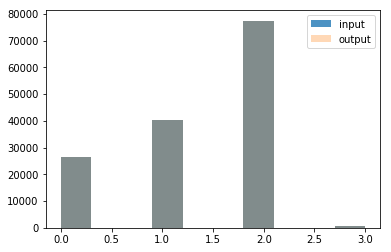

In [72]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

#### Original data

In [73]:
X_input_ori = X_input_num  # Do not contain nan
Y_input_ori = Y_input_num
X_output_ori = X_output_num
if test_length:
    Y_output_ori = Y_output_num

In [74]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -105.72 65.6597 -0.426356 4.16166
(145063, 63) -105.72 83.3111 -0.266025 4.15278
(145063, 63) -74.7194 8.00102 0.0 1.32028
(145063, 63) -74.7194 113.196 0.0 2.31239
(145063, 63) 0.0 2.15536e+07 75.0 64150.7
(145063, 63) 0.0 2.13664e+07 88.0 62373.1
(145063, 63) 0.0 3.3447e+07 139.0 87516.7
(145063, 63) 0.0 2.83429e+07 143.0 81329.6


arr_info((Z_input,))

#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, X_input_center, X_input_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

del X_input_tt_diff; del X_input_tt

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [75]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

Z_input_list = [Z_input[input_gp == gp] for gp in gp_list]
Z_output_list = [Z_output[output_gp == gp] for gp in gp_list]

## Additional input for the neural network

#Split center into group
Y_input_center_list = [Y_input_center[input_gp == gp] for gp in gp_list]
Y_output_center_list = [Y_output_center[output_gp == gp] for gp in gp_list]

#Split scale into group
input_scale_list = [input_scale[input_gp == gp] for gp in gp_list]
output_scale_list = [output_scale[output_gp == gp] for gp in gp_list]

input_scale_list[0].shape

In [76]:
A_input = np.concatenate((Y_input_center, input_scale), axis=1)
A_output = np.concatenate((Y_output_center, output_scale), axis=1); A_input.shape, A_output.shape

((145063, 2), (145063, 2))

In [77]:
A_input_list = [A_input[input_gp == gp] for gp in gp_list]
A_output_list = [A_output[output_gp == gp] for gp in gp_list]

In [78]:
a_length = len(A_input[0]); a_length

2

## Neural Network?

In [79]:
import keras

Using TensorFlow backend.


In [80]:
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [81]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [82]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

In [83]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(106.06488, 147.63559, 0.0)

In [84]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(56.816025, 51.874931)

In [85]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

58.1163 141.793


In [86]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

45.4365
45.8795


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [87]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import concatenate

In [88]:
n_ens = 5
ens_list = list(range(n_ens))

In [89]:
#runbelow
models_ens = []
for run in ens_list:
    print('Run', run, end=': ')
    models = []
    for gp in gp_list:
        print('Group-', gp, sep='', end=' ')
        layer_0 = Input(shape=(x_length,), name='x_input')
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(120, kernel_size=3, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_cnn_x = Flatten()(layer_t)
        
        layer_a = Input(shape=(a_length,), name='a_input')
        
        #layer_z = Input(shape=(y_length,), name='z_input')
        #layer_t = Reshape((-1, 1))(layer_0)
        #layer_t = Conv1D(20, kernel_size=3, activation='relu')(layer_t)
        #layer_t = AveragePooling1D(pool_size=2)(layer_t)
        #layer_cnn_z = Flatten()(layer_t)
                
        layer_t = concatenate([layer_cnn_x, layer_a])#, layer_cnn_z])
        
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.25)(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.5)(layer_t)
        layer_f = Dense(y_length)(layer_t)
        
        model = Model(inputs=[layer_0, layer_a], outputs=layer_f)
        #model = Model(inputs=[layer_0, layer_a, layer_z], outputs=layer_f)
        model.compile(optimizer='adam',
                      loss='mean_absolute_error', metrics=[k_smape])
        #model.summary()
        models.append(model)
    models_ens.append(models)
    print('')

Run 0: Group-0 Group-1 Group-2 Group-3 
Run 1: Group-0 Group-1 Group-2 Group-3 
Run 2: Group-0 Group-1 Group-2 Group-3 
Run 3: Group-0 Group-1 Group-2 Group-3 
Run 4: Group-0 Group-1 Group-2 Group-3 


In [90]:
models_ens[-1][-1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x_input (InputLayer)             (None, 63)            0                                            
____________________________________________________________________________________________________
reshape_20 (Reshape)             (None, 63, 1)         0           x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_20 (Conv1D)               (None, 61, 120)       480         reshape_20[0][0]                 
____________________________________________________________________________________________________
average_pooling1d_20 (AveragePoo (None, 30, 120)       0           conv1d_20[0][0]                  
___________________________________________________________________________________________

In [91]:
np.array(models_ens).shape

(5, 4)

In [92]:
len(gp_list)

4

In [93]:
epochs_list = [1,40,40,60]  # change to smaller epochs later (1,1,20,40,60,80)

In [94]:
%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

=== Run: 1 / 5 ===
--- Group: 1 / 4 ---
Train on 23874 samples, validate on 2653 samples
Epoch 1/1
8s - loss: 0.9387 - k_smape: 142.8604 - val_loss: 0.8042 - val_k_smape: 142.2145
--- Group: 2 / 4 ---
Train on 36237 samples, validate on 4027 samples
Epoch 1/40
8s - loss: 1.2340 - k_smape: 118.3985 - val_loss: 0.8624 - val_k_smape: 125.0489
Epoch 2/40
8s - loss: 1.1147 - k_smape: 108.9040 - val_loss: 0.8225 - val_k_smape: 120.1948
Epoch 3/40
7s - loss: 1.0963 - k_smape: 107.4273 - val_loss: 0.7614 - val_k_smape: 114.5878
Epoch 4/40
8s - loss: 1.0878 - k_smape: 107.2730 - val_loss: 0.8091 - val_k_smape: 118.6710
Epoch 5/40
8s - loss: 1.0752 - k_smape: 106.5355 - val_loss: 0.8010 - val_k_smape: 115.7853
Epoch 6/40
7s - loss: 1.0709 - k_smape: 106.4721 - val_loss: 0.7446 - val_k_smape: 116.1815
Epoch 7/40
7s - loss: 1.0700 - k_smape: 106.0793 - val_loss: 0.8135 - val_k_smape: 117.0201
Epoch 8/40
7s - loss: 1.0623 - k_smape: 106.0728 - val_loss: 0.8181 - val_k_smape: 119.8058
Epoch 9/40
7s 

0s - loss: 2.6571 - k_smape: 107.6665 - val_loss: 3.0049 - val_k_smape: 107.9723
Epoch 8/60
0s - loss: 2.5899 - k_smape: 105.3781 - val_loss: 2.9116 - val_k_smape: 105.4734
Epoch 9/60
0s - loss: 2.7739 - k_smape: 110.1232 - val_loss: 3.0925 - val_k_smape: 104.9241
Epoch 10/60
0s - loss: 2.6891 - k_smape: 100.7586 - val_loss: 1.8156 - val_k_smape: 93.0802
Epoch 11/60
0s - loss: 2.5947 - k_smape: 99.0892 - val_loss: 2.7559 - val_k_smape: 102.5505
Epoch 12/60
0s - loss: 2.5115 - k_smape: 102.1026 - val_loss: 2.5804 - val_k_smape: 102.5309
Epoch 13/60
0s - loss: 2.3821 - k_smape: 99.5041 - val_loss: 2.1297 - val_k_smape: 96.0642
Epoch 14/60
0s - loss: 2.3082 - k_smape: 96.9775 - val_loss: 2.3793 - val_k_smape: 96.1232
Epoch 15/60
0s - loss: 2.3342 - k_smape: 96.0431 - val_loss: 2.1963 - val_k_smape: 93.0399
Epoch 16/60
0s - loss: 2.2406 - k_smape: 95.0993 - val_loss: 1.7947 - val_k_smape: 91.5351
Epoch 17/60
0s - loss: 2.4422 - k_smape: 92.8484 - val_loss: 1.5022 - val_k_smape: 89.0098
Epo

7s - loss: 1.0315 - k_smape: 103.7635 - val_loss: 0.8323 - val_k_smape: 118.3026
Epoch 35/40
7s - loss: 1.0303 - k_smape: 103.5260 - val_loss: 0.8279 - val_k_smape: 116.0785
Epoch 36/40
7s - loss: 1.0238 - k_smape: 103.5324 - val_loss: 0.8282 - val_k_smape: 118.1718
Epoch 37/40
7s - loss: 1.0246 - k_smape: 103.3625 - val_loss: 0.8130 - val_k_smape: 115.8471
Epoch 38/40
7s - loss: 1.0272 - k_smape: 103.4204 - val_loss: 0.8033 - val_k_smape: 114.7128
Epoch 39/40
7s - loss: 1.0268 - k_smape: 103.3271 - val_loss: 0.7804 - val_k_smape: 112.8131
Epoch 40/40
7s - loss: 1.0222 - k_smape: 103.3488 - val_loss: 0.8447 - val_k_smape: 115.7780
--- Group: 3 / 4 ---
Train on 69674 samples, validate on 7742 samples
Epoch 1/40
15s - loss: 1.4494 - k_smape: 103.2908 - val_loss: 1.0239 - val_k_smape: 99.4328
Epoch 2/40
15s - loss: 1.2929 - k_smape: 95.1868 - val_loss: 1.0568 - val_k_smape: 98.7293
Epoch 3/40
15s - loss: 1.2654 - k_smape: 94.0373 - val_loss: 1.0199 - val_k_smape: 98.4646
Epoch 4/40
15s - 

0s - loss: 1.8718 - k_smape: 86.1916 - val_loss: 1.4109 - val_k_smape: 86.6631
Epoch 44/60
0s - loss: 1.8604 - k_smape: 85.0183 - val_loss: 2.0563 - val_k_smape: 90.5772
Epoch 45/60
0s - loss: 1.8593 - k_smape: 85.1979 - val_loss: 2.2627 - val_k_smape: 89.1753
Epoch 46/60
0s - loss: 2.3466 - k_smape: 90.2793 - val_loss: 2.8446 - val_k_smape: 92.2067
Epoch 47/60
0s - loss: 2.0229 - k_smape: 83.7299 - val_loss: 1.6611 - val_k_smape: 86.6396
Epoch 48/60
0s - loss: 2.0019 - k_smape: 83.8035 - val_loss: 2.4101 - val_k_smape: 97.4252
Epoch 49/60
0s - loss: 2.0790 - k_smape: 89.2319 - val_loss: 1.7021 - val_k_smape: 90.4984
Epoch 50/60
0s - loss: 1.8921 - k_smape: 83.6495 - val_loss: 1.5018 - val_k_smape: 86.0762
Epoch 51/60
0s - loss: 1.8697 - k_smape: 83.2380 - val_loss: 1.9949 - val_k_smape: 87.7232
Epoch 52/60
0s - loss: 1.8292 - k_smape: 82.6922 - val_loss: 1.3327 - val_k_smape: 84.6497
Epoch 53/60
0s - loss: 2.0454 - k_smape: 82.0575 - val_loss: 2.7480 - val_k_smape: 95.2957
Epoch 54/60

15s - loss: 1.1880 - k_smape: 90.2063 - val_loss: 1.0117 - val_k_smape: 96.1382
Epoch 30/40
15s - loss: 1.1883 - k_smape: 90.2212 - val_loss: 1.0685 - val_k_smape: 96.6736
Epoch 31/40
15s - loss: 1.1868 - k_smape: 90.1394 - val_loss: 1.0697 - val_k_smape: 97.0573
Epoch 32/40
15s - loss: 1.1890 - k_smape: 90.0764 - val_loss: 1.1150 - val_k_smape: 99.0342
Epoch 33/40
15s - loss: 1.1832 - k_smape: 90.0532 - val_loss: 1.0734 - val_k_smape: 98.5026
Epoch 34/40
15s - loss: 1.1834 - k_smape: 89.7120 - val_loss: 1.0564 - val_k_smape: 96.5966
Epoch 35/40
15s - loss: 1.1836 - k_smape: 89.8359 - val_loss: 1.0535 - val_k_smape: 96.5181
Epoch 36/40
16s - loss: 1.1779 - k_smape: 89.8414 - val_loss: 1.0936 - val_k_smape: 96.4308
Epoch 37/40
15s - loss: 1.1822 - k_smape: 89.8187 - val_loss: 1.0936 - val_k_smape: 97.4541
Epoch 38/40
15s - loss: 1.1751 - k_smape: 89.5657 - val_loss: 1.0696 - val_k_smape: 97.2630
Epoch 39/40
15s - loss: 1.1776 - k_smape: 89.5626 - val_loss: 1.0746 - val_k_smape: 95.9221


8s - loss: 1.0499 - k_smape: 105.0960 - val_loss: 0.8548 - val_k_smape: 118.9468
Epoch 17/40
8s - loss: 1.0477 - k_smape: 104.8772 - val_loss: 0.8562 - val_k_smape: 116.7501
Epoch 18/40
8s - loss: 1.0445 - k_smape: 104.8148 - val_loss: 0.8298 - val_k_smape: 119.0111
Epoch 19/40
8s - loss: 1.0470 - k_smape: 104.7488 - val_loss: 0.8388 - val_k_smape: 120.2471
Epoch 20/40
8s - loss: 1.0430 - k_smape: 104.5605 - val_loss: 0.8329 - val_k_smape: 116.7776
Epoch 21/40
8s - loss: 1.0466 - k_smape: 104.7342 - val_loss: 0.8056 - val_k_smape: 115.4556
Epoch 22/40
8s - loss: 1.0441 - k_smape: 104.5680 - val_loss: 0.8437 - val_k_smape: 115.7183
Epoch 23/40
8s - loss: 1.0425 - k_smape: 104.4091 - val_loss: 0.8334 - val_k_smape: 119.6067
Epoch 24/40
8s - loss: 1.0390 - k_smape: 104.3873 - val_loss: 0.8603 - val_k_smape: 117.7519
Epoch 25/40
8s - loss: 1.0407 - k_smape: 104.3317 - val_loss: 0.8278 - val_k_smape: 114.0312
Epoch 26/40
8s - loss: 1.0383 - k_smape: 104.1446 - val_loss: 0.8142 - val_k_smape

0s - loss: 2.0498 - k_smape: 93.4099 - val_loss: 1.5889 - val_k_smape: 96.7092
Epoch 26/60
0s - loss: 2.1425 - k_smape: 90.2343 - val_loss: 2.0906 - val_k_smape: 93.8067
Epoch 27/60
0s - loss: 2.0420 - k_smape: 91.8872 - val_loss: 1.4858 - val_k_smape: 88.4552
Epoch 28/60
0s - loss: 1.9770 - k_smape: 89.2428 - val_loss: 1.8563 - val_k_smape: 91.2823
Epoch 29/60
0s - loss: 2.0171 - k_smape: 88.8893 - val_loss: 1.7711 - val_k_smape: 91.1096
Epoch 30/60
0s - loss: 1.9526 - k_smape: 89.8135 - val_loss: 1.7639 - val_k_smape: 93.1040
Epoch 31/60
0s - loss: 1.9365 - k_smape: 89.1080 - val_loss: 1.5359 - val_k_smape: 90.4156
Epoch 32/60
0s - loss: 1.9128 - k_smape: 86.8911 - val_loss: 2.0452 - val_k_smape: 91.6067
Epoch 33/60
0s - loss: 1.9255 - k_smape: 87.6349 - val_loss: 1.4251 - val_k_smape: 91.9944
Epoch 34/60
0s - loss: 1.9312 - k_smape: 86.5186 - val_loss: 2.8399 - val_k_smape: 104.2368
Epoch 35/60
0s - loss: 2.3838 - k_smape: 99.6223 - val_loss: 1.8019 - val_k_smape: 105.6545
Epoch 36/

15s - loss: 1.2146 - k_smape: 91.7641 - val_loss: 1.0024 - val_k_smape: 96.0155
Epoch 12/40
15s - loss: 1.2129 - k_smape: 91.3874 - val_loss: 0.9856 - val_k_smape: 97.1769
Epoch 13/40
16s - loss: 1.2180 - k_smape: 91.3830 - val_loss: 0.9831 - val_k_smape: 97.3864
Epoch 14/40
15s - loss: 1.2084 - k_smape: 91.0853 - val_loss: 1.0392 - val_k_smape: 96.8949
Epoch 15/40
15s - loss: 1.2114 - k_smape: 91.1110 - val_loss: 1.0127 - val_k_smape: 96.2134
Epoch 16/40
15s - loss: 1.2036 - k_smape: 90.8365 - val_loss: 1.0422 - val_k_smape: 97.4361
Epoch 17/40
15s - loss: 1.1994 - k_smape: 90.7241 - val_loss: 0.9986 - val_k_smape: 95.1877
Epoch 18/40
15s - loss: 1.1987 - k_smape: 90.6540 - val_loss: 0.9869 - val_k_smape: 96.4319
Epoch 19/40
16s - loss: 1.1982 - k_smape: 90.5630 - val_loss: 0.9707 - val_k_smape: 95.3073
Epoch 20/40
16s - loss: 1.1983 - k_smape: 90.3657 - val_loss: 1.0073 - val_k_smape: 96.3340
Epoch 21/40
16s - loss: 1.1964 - k_smape: 90.4508 - val_loss: 1.0106 - val_k_smape: 97.3214


%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in, Z_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list, Z_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in, Z_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

### Training History

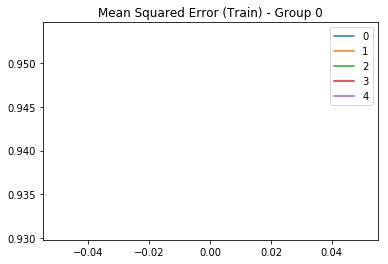

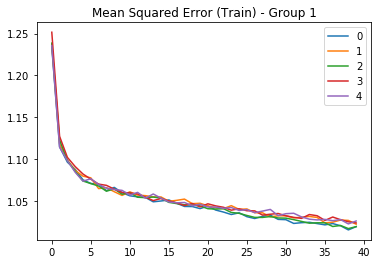

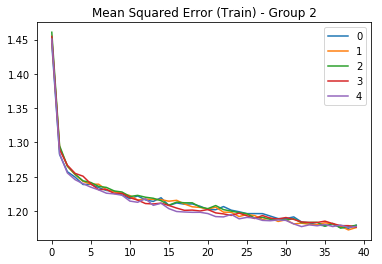

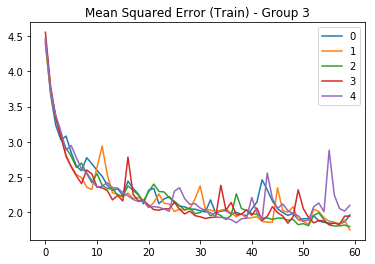

In [95]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

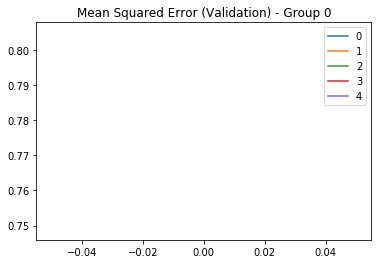

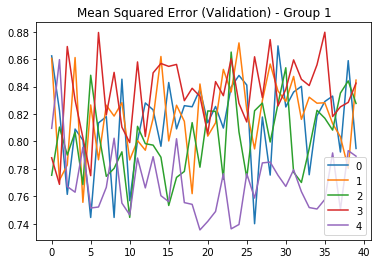

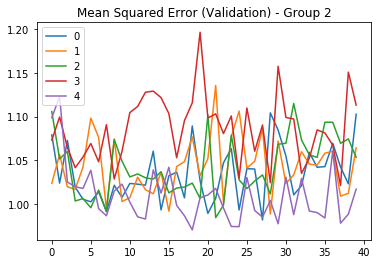

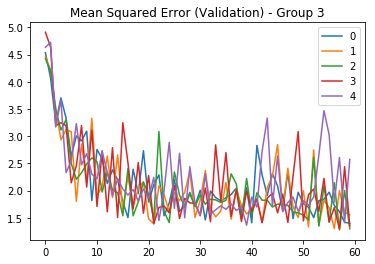

In [96]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

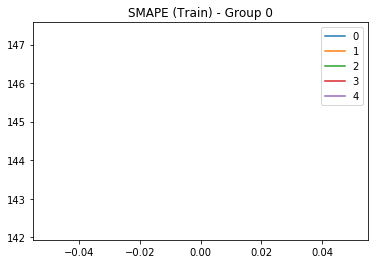

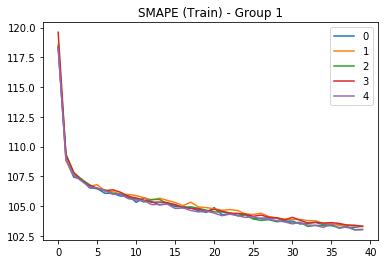

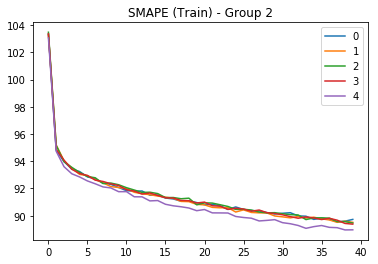

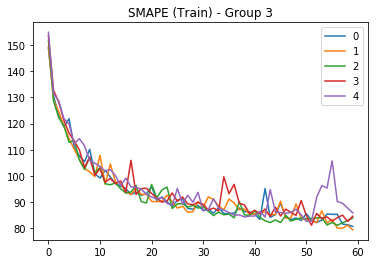

In [97]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

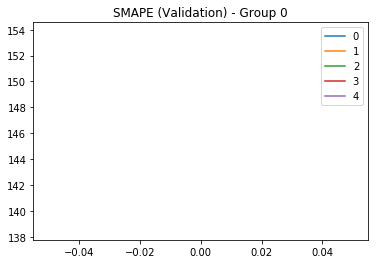

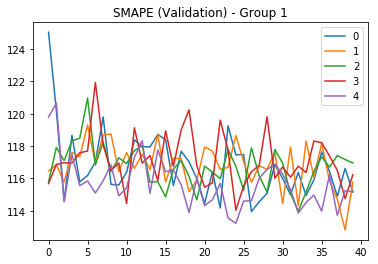

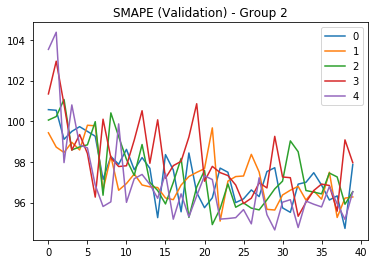

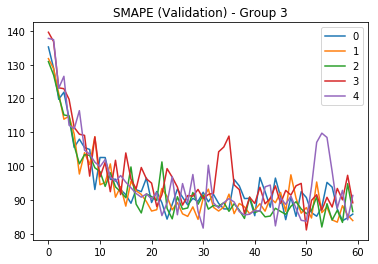

In [98]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

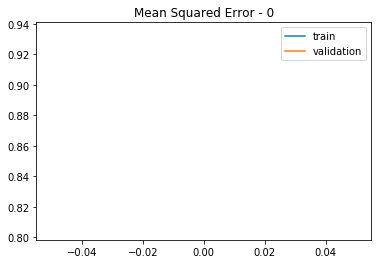

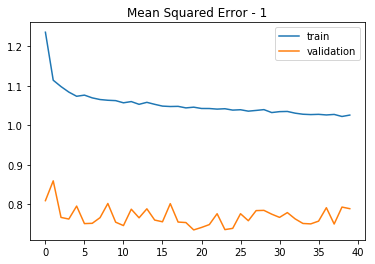

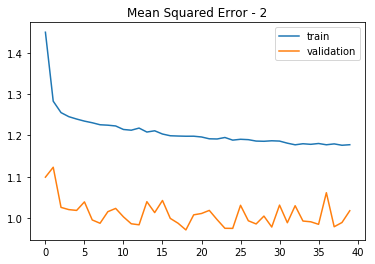

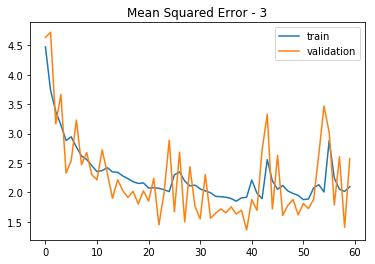

In [99]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

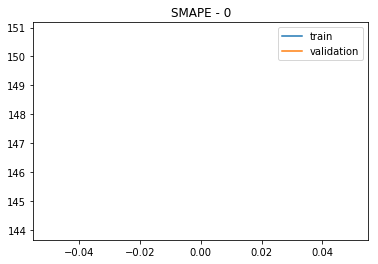

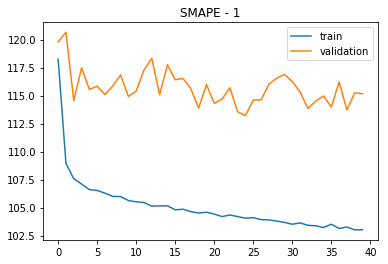

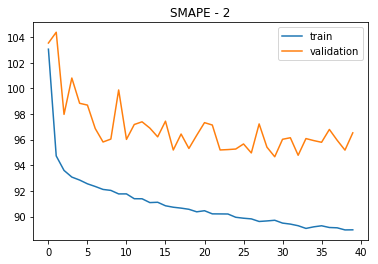

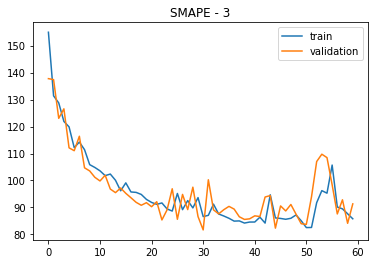

In [100]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

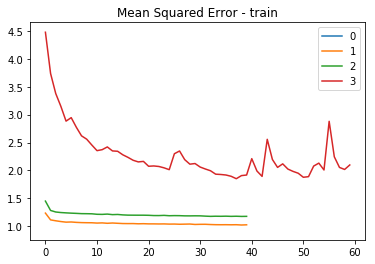

In [101]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

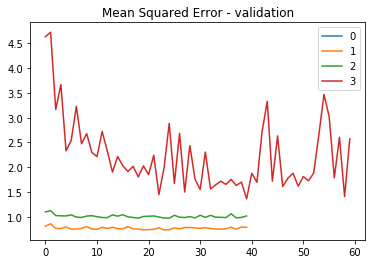

In [102]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

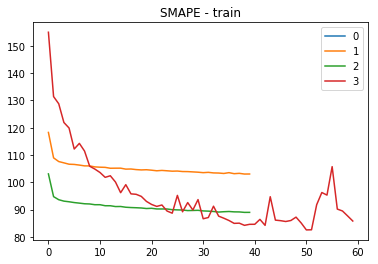

In [103]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

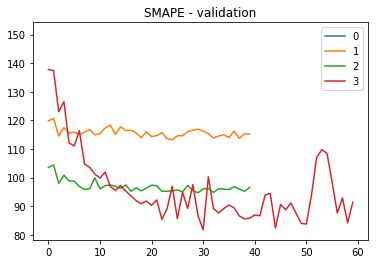

In [104]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

## Predict for Input Set (Training Set)

In [105]:
%%time
Y_input_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_input_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_input_list, A_input_list):
        print(gp, end=' ')
        Y_input_pred_list.append(model.predict([X, A]))
    Y_input_pred_list_ens.append(Y_input_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 1min 10s


%%time
Y_input_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_input_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_input_list, A_input_list, Z_input_list):
        print(gp, end=' ')
        Y_input_pred_list.append(model.predict([X, A, Z]))
    Y_input_pred_list_ens.append(Y_input_pred_list)
    print('')

Find the original index

In [106]:
input_index_range = np.arange(len(input_gp)); #input_index_range

In [107]:
# list for original index
input_index_list = [input_index_range[input_gp == gp] 
                     for gp in gp_list]

In [108]:
for o in input_index_list:
    print(o.shape, end=' ')

(26527,) (40264,) (77416,) (856,) 

In [109]:
input_index_list_comb = np.concatenate(input_index_list); #input_index_list_comb

In [110]:
Y_input_pred_ens = []
for Y_input_pred_list in Y_input_pred_list_ens:
    Y_input_pred_comb = np.concatenate(Y_input_pred_list)
    Y_input_pred = [0]*len(input_index_list_comb)

    for index, y in zip(input_index_list_comb, Y_input_pred_comb):
        Y_input_pred[index] = y

    Y_input_pred = np.array(Y_input_pred)  # make it an numpy array (which will also make a copy)
    Y_input_pred_ens.append(Y_input_pred)

del Y_input_pred_comb

In [111]:
# Inverse transform Y_input_pred to original Y
Y_input_pred_ori_ens = []
for Y_input_pred in Y_input_pred_ens:
    Y_input_pred_ori = unlog(untransform(Y_input_pred, 
                                          Y_input_center, Y_input_scale))
    Y_input_pred_ori_ens.append(Y_input_pred_ori)

In [112]:
Y_input_pred_ori_ens = np.array(Y_input_pred_ori_ens)

## Predict for Output Set

In [113]:
%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_output_list, A_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 1min 9s


%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_output_list, A_output_list, Z_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A, Z]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Find the original index

In [114]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [115]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [116]:
for o in output_index_list:
    print(o.shape, end=' ')

(26527,) (40264,) (77416,) (856,) 

In [117]:
output_index_list_comb = np.concatenate(output_index_list); #output_index_list_comb

In [118]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred[index] = y

    Y_output_pred = np.array(Y_output_pred)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_comb

In [119]:
# Inverse transform Y_output_pred to original Y
Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          Y_output_center, Y_output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)

In [120]:
Y_output_pred_ori_ens = np.array(Y_output_pred_ori_ens)

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(X_output_ori[126420])

## SMAPE Scores

### Model Score

In [121]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    
    model_smape_stdev = np.std(model_smape_ens)  # standard deviation of the smape score
    model_smape_0_stdev = np.std(model_smape_0_ens)  # standard deviation of the smape score
    
    model_smape_ens_mean_std = model_smape_stdev / np.sqrt(len(model_smape_ens))

In [122]:
if test_length:
    for model_smape, model_smape_0 in zip(model_smape_ens, model_smape_0_ens):
        print('%6.3f' % model_smape, '       ', '%6.3f' % model_smape_0)
    print('-----------------------------')
    print('%6.3f' % model_smape_ens_mean, '+-%5.3f' % model_smape_stdev, 
          '%6.3f' % model_smape_0_ens_mean, '+-%5.3f' % model_smape_0_stdev)
    print('+-%5.3f' % model_smape_ens_mean_std)

43.658         46.377
43.744         46.523
43.827         46.563
43.521         46.320
43.643         46.512
-----------------------------
43.679 +-0.103 46.459 +-0.094
+-0.046


In [123]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

45.8795


### Group Scores

In [124]:
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ens[-1]  # in case you want to see one of them

In [125]:
# Fibonacci median in group
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [126]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [127]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [128]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

if test_length: print(count_not_nan(Y_output_raw))

In [129]:
# Group scores for the model
if test_length:
    gp_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]    

In [130]:
gp_smape_mean = np.mean(gp_smape_ens, axis=0); gp_smape_mean

array([ 71.18693542,  43.89302826,  35.50675583,  38.91547394], dtype=float32)

if test_length:
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    #n_not_nan = count_not_nan(Y_output_raw)
    #n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    #n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
    #                      in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [131]:
# Group score for Fibonacci median
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [132]:
if test_length:  # gp_score compare
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|  Total ', ' %7.3f ' % fib_smape, ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

#### model_10_Modified_CNN_4_The_Model_1_stage_1_train
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  26527 |  65.475 |  71.187 |  71.549 |  71.628 |  72.110 |  69.617 |  71.031 |
|  40264 |  45.496 |  43.893 |  43.833 |  43.877 |  43.889 |  44.077 |  43.790 |
|  77416 |  40.368 |  35.507 |  35.398 |  35.502 |  35.508 |  35.588 |  35.538 |
|    856 |  39.507 |  38.915 |  38.593 |  39.097 |  38.909 |  38.792 |  39.187 |
|  Total |  45.879 |  43.679 |  43.658 |  43.744 |  43.827 |  43.521 |  43.643 |

#### model_10_Modified_CNN_4_The_Model
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|  Total |  40.404 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |
#### model_10_Modified_CNN_1_Z
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 158.876 | 166.920 | 167.117 | 154.478 | 165.189 | 140.678 |
|  23085 |  61.354 |  64.057 |  63.166 |  63.533 |  63.921 |  64.384 |  65.282 |
|  43691 |  40.612 |  40.025 |  40.088 |  39.890 |  40.224 |  40.132 |  39.794 |
|  75617 |  34.284 |  29.755 |  29.759 |  29.741 |  29.658 |  29.865 |  29.752 |
|    740 |  35.621 |  33.983 |  33.411 |  33.945 |  34.447 |  34.013 |  34.100 |
|     51 |  20.224 |  17.259 |  17.687 |  17.204 |  17.227 |  17.300 |  16.878 |
|  Total |  40.404 |  38.937 |  38.881 |  38.869 |  38.897 |  39.122 |  38.914 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|  Total |  40.404 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape, '%6.2f' % model_smape_0)

n_not_nan_gp

### Page Scores

In [133]:
if test_length:  # Page scores for the model
    smape_Y_pred_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ens.append(smape_Y_pred)

c:\python3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [134]:
if test_length:  # Page score for Fib.
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

c:\python3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


if test_length:
    for smape_Y_pred in smape_Y_pred_ens:
        plt.hist(smape_Y_pred, bins=40, alpha=0.4)
        #plt.yscale('log')
    plt.title('Ensemble Page SMAPE'); plt.show()

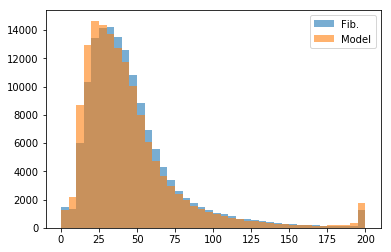

In [135]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6, label='Fib.')
    plt.hist(smape_Y_pred, bins=40, alpha=0.6, label='Model')
    #plt.yscale('log')
    plt.legend(); plt.show()

### Page Scores in Each Group

In [136]:
if test_length:  # The model
    smape_Y_pred_list_ens = []
    for smape_Y_pred in smape_Y_pred_ens:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ens.append(smape_Y_pred_list)

In [137]:
if test_length:  # Fib.
    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

#### Plots

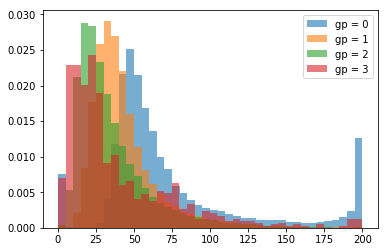

In [138]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

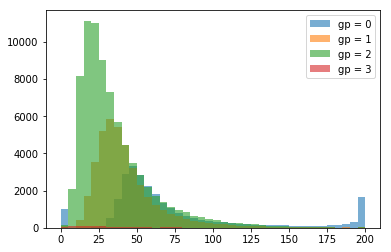

In [139]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

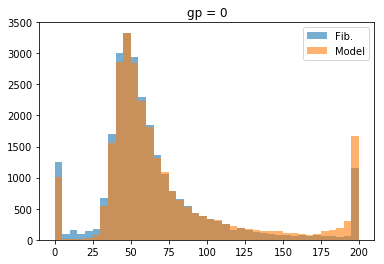

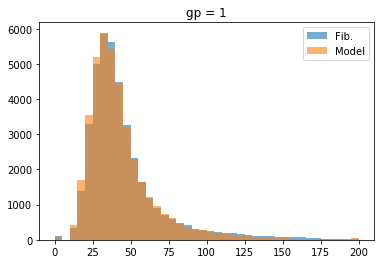

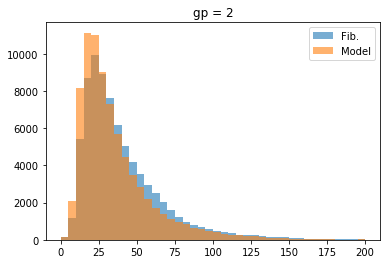

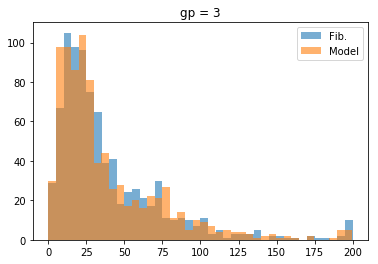

In [140]:
if test_length:
    for gp in gp_list:
        plt.hist(smape_Y_fib_list[gp], bins=40, alpha=0.6, label='Fib.')
        plt.hist(smape_Y_pred_list[gp], bins=40, alpha=0.6, label='Model')
        plt.title('gp = '+str(gp)); plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

## Prediction Pre Combine
Combine group 0, 1 from Fib and rest from the model

Y_output_fib.shape

In [141]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [142]:
# Select group 0 from Fib.
fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [143]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

Y_output_fmc_ori

#### Pre Combined Score

In [144]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [145]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

42.677 (43.658) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 0
42.749 (43.744) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 1
42.754 (43.827) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 2
42.852 (43.521) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 3
42.745 (43.643) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 4
42.755 (43.679) - model_10_Modified_CNN_4_The_Model_1_stage_1_train Average


## Ensemble Learning

### Ensemble Median

In [146]:
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)
Y_output_pred_ori_ens_med.shape

(145063, 63)

Y_output_pred_ori_ens_med

In [147]:
ens_med_smape = smape(Y_output_pred_ori_ens_med, Y_output_raw); ens_med_smape

43.447029

Best ways seem to be taking median either before or after transformation.

### Ensemble Combine with Fibonacci Median

In [148]:
#Replace group 0 by Fib. Median
fib_mask = ((output_gp == 0)).reshape(-1,1); fib_mask.shape
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [149]:
#Y_output_f_omean = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_mean
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med  # Our final output
#Y_output_f_meano = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_mean_ori
#Y_output_f_medo  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ens_med_ori

## All Model Scores

In [150]:
if test_length:  # Ensemble learning model score
    #f_omean_smape = smape(Y_output_raw, Y_output_f_omean)
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)
    #f_meano_smape = smape(Y_output_raw, Y_output_f_meano)
    #f_medo_smape = smape(Y_output_raw, Y_output_f_medo)

In [151]:
if test_length: # The_score with (without) combining Fibonacci median model
    #print('%6.3f         ' % f_omean_smape, '-', model_name, 'ori_ens_mean')
    print('%6.3f' % f_omed_smape, '(%6.3f)' % ens_med_smape,'-', model_name, 'ori_ensemble_median')
    #print('%6.3f         ' % f_meano_smape, '-', model_name, 'ens_mean_ori')
    #print('%6.3f         ' % f_medo_smape, '-', model_name, 'ens_med_ori')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)

42.464 (43.447) - model_10_Modified_CNN_4_The_Model_1_stage_1_train ori_ensemble_median
42.755 (43.679) - model_10_Modified_CNN_4_The_Model_1_stage_1_train Average
42.677 (43.658) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 0
42.749 (43.744) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 1
42.754 (43.827) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 2
42.852 (43.521) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 3
42.745 (43.643) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 4


42.464 (43.447) - model_10_Modified_CNN_4_The_Model_1_stage_1_train ori_ensemble_median
42.755 (43.679) - model_10_Modified_CNN_4_The_Model_1_stage_1_train Average
42.677 (43.658) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 0
42.749 (43.744) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 1
42.754 (43.827) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 2
42.852 (43.521) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 3
42.745 (43.643) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 4

37.429 (38.536) - model_10_Modified_CNN_4_The_Model ori_ensemble_median
37.731 (38.836) - model_10_Modified_CNN_4_The_Model Average
37.699 (38.826) - model_10_Modified_CNN_4_The_Model 0
37.623 (38.677) - model_10_Modified_CNN_4_The_Model 1
37.763 (38.829) - model_10_Modified_CNN_4_The_Model 2
37.748 (38.889) - model_10_Modified_CNN_4_The_Model 3
37.821 (38.957) - model_10_Modified_CNN_4_The_Model 4

37.436          - model_10_Modified_CNN_0_median_stdev ori_ens_mean
37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med
37.394          - model_10_Modified_CNN_0_median_stdev ens_mean_ori
37.382          - model_10_Modified_CNN_0_median_stdev ens_med_ori
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

Ensemble of model are all better than the individual model.

fmc_smape_ens

fmc_smape_ens_mean

 Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

#### Stage 2 Scores:
37.473          - model_10_Modified_CNN_1_Z ori_ensemble_median

37.535          - model_10_Modified_CNN_0_median_stdev_2_3_groups ori_ensemble_median

37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med

37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

#### Stage 1 Scores:
42.464 (43.447) - model_10_Modified_CNN_4_The_Model_1_stage_1_train ori_ensemble_median

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## All Group Scores

In [152]:
# ensemble result Y_output in each group
#Y_output_pred_ori_ens_mean_list = [Y_output_pred_ori_ens_mean[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_ens_med_list = [Y_output_pred_ori_ens_med[output_gp == gp] for gp in gp_list]
#Y_output_pred_ens_mean_ori_list = [Y_output_pred_ens_mean_ori[output_gp == gp] for gp in gp_list]
#Y_output_pred_ens_med_ori_list = [Y_output_pred_ens_med_ori[output_gp == gp] for gp in gp_list]

In [153]:
# Group SMAPE scores
if test_length:
    # SMAPE with nan values ignored (used by Kaggle)
    #gp_omean_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_mean_list)]
    gp_omed_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_med_list)]
    #gp_meano_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ens_mean_ori_list)]


In [154]:
if test_length:  # The_gp_score
    print('#### ' + model_name)
    print('', end='|')
    print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        #print(' %7.3f ' % gp_omean_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        #print(' %7.3f ' % gp_meano_smape[gp], end='|')
        #print(' %7.3f ' % gp_medo_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
          ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

#### model_10_Modified_CNN_4_The_Model_1_stage_1_train
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  26527 |  65.475 |  71.555 |  71.187 |  71.549 |  71.628 |  72.110 |  69.617 |  71.031 |
|  40264 |  45.496 |  43.537 |  43.893 |  43.833 |  43.877 |  43.889 |  44.077 |  43.790 |
|  77416 |  40.368 |  35.163 |  35.507 |  35.398 |  35.502 |  35.508 |  35.588 |  35.538 |
|    856 |  39.507 |  38.669 |  38.915 |  38.593 |  39.097 |  38.909 |  38.792 |  39.187 |
|Over All|  45.879 |  42.464 |  43.679 |  43.658 |  43.744 |  43.827 |  43.521 |  43.643 |

#### model_10_Modified_CNN_4_The_Model
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.304 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.627 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.275 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.112 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|Over All|  40.404 |  37.429 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.909 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  39.821 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.400 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|Over All|  40.404 |  37.535 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.741 | 172.496 | 191.624 | 172.496 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.110 |  64.122 |  64.116 |  64.122 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.620 |  39.564 |  39.574 |  39.564 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.300 |  29.231 |  29.248 |  29.231 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.403 |  33.482 |  33.373 |  33.482 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.360 |  16.338 |  16.361 |  16.338 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.921 | 173.799 | 189.346 | 173.799 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  63.635 |  63.651 |  63.644 |  63.651 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  39.693 |  39.628 |  39.637 |  39.628 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  29.444 |  29.368 |  29.381 |  29.368 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.858 |  33.893 |  33.837 |  33.893 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.861 |  16.948 |  16.856 |  16.948 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

## More Explore

## Optimize Group Models

### Group Models in other Groups

In [162]:
%%time
Y_output_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_output, A_output]), 
                                                         Y_output_center, output_scale) 
                                            for model in models] for models in models_ens]))
#Take 4 min on PC and NB

Wall time: 4min 5s


In [163]:
Y_output_all_ori_list_ens.shape  # (Ensemble, Group model, Y, y)

(5, 4, 145063, 63)

In [164]:
#Take Ensemble median
Y_output_all_ori_list_ens_med = np.median(Y_output_all_ori_list_ens, axis=0); Y_output_all_ori_list_ens_med.shape

(4, 145063, 63)

In [199]:
#Group scores for each group models
#row index: group model; column index: group of Y
smape_gpm_gp_ens_med = [[smape(Y, Y_p[output_gp == gp]) for gp, Y in zip(gp_list, Y_output_raw_list)] 
                        for Y_p in Y_output_all_ori_list_ens_med]

Wall time: 874 ms


%%time
smape_gpm_gp_ens = []
for run in ens_list:
    print('Run', run)
    models = models_ens[run]
    Y_output_all_ori_list = unlog(np.array([untransform(model.predict([X_output, A_output]), 
                                                        Y_output_center, output_scale) 
                                            for model in models]))
    # row: model of the group; column: group of Y
    smape_gpm_gp = [[smape(Y, Y_p[output_gp == gp]) for gp, Y in zip(gp_list, Y_output_raw_list)] 
                    for Y_p in Y_output_all_ori_list]
    smape_gpm_gp_ens.append(smape_gpm_gp)
smape_gpm_gp_ens = np.array(smape_gpm_gp_ens)

smape_gpm_gp_mean = np.mean(smape_gpm_gp_ens, axis=0)

In [200]:
print('Ens. Median   ', end='|')
for j in range(len(smape_gpm_gp_ens_med[0])): print(' group', j, end='|')
print('')
print('--------------', end='|')
for j in range(len(smape_gpm_gp_ens_med[0])): print('--------', end='|')
print('')
for i in range(len(smape_gpm_gp_ens_med)):
    print('group model', i, end=' |')
    for j in range(len(smape_gpm_gp_ens_med[0])):
        print(' %6.2f ' % smape_gpm_gp_ens_med[i][j], end='|')
    print('')

Ens. Median   | group 0| group 1| group 2| group 3|
--------------|--------|--------|--------|--------|
group model 0 |  71.56 |  46.07 |  41.62 |  41.11 |
group model 1 |  71.61 |  43.54 |  37.01 |  36.67 |
group model 2 |  72.45 |  43.90 |  35.16 |  34.84 |
group model 3 |  71.72 |  46.67 |  40.07 |  38.67 |


Only group model 2 and 3 are useful

In [201]:
for x in gp_omed_smape: print(' %6.2f ' % x, end='|')

  71.56 |  43.54 |  35.16 |  38.67 |

In [202]:
for x in gp_smape_fib: print(' %6.2f ' % x, end='|')

  65.47 |  45.50 |  40.37 |  39.51 |

Group 4 is better at group 3 model. Group 5 is better at group 2 or 3 model

### Optimized Group Models

In [203]:
gpm_list = np.argmin(smape_gpm_gp_mean,axis=0)

print(model_name,'gpm_list = [', end='')
for x in gpm_list: print(x, end=',')
print(']')

model_10_Modified_CNN_4_The_Model_1_stage_1_train gpm_list = [0,1,2,2,]


In [204]:
gpm_mask = np.array([gpm_list == gp for gp in gp_list]).T; gpm_mask

array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False,  True, False]], dtype=bool)

In [205]:
Y_output_ori_list_ens_med_temp = np.tensordot(gpm_mask, Y_output_all_ori_list_ens_med, axes=([1],[0]))

In [206]:
gp_mask = np.array([output_gp == gp for gp in gp_list]); gp_mask

array([[False, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [207]:
gp_mask_reshape = gp_mask.reshape(len(gp_mask),len(gp_mask[0]),1); gp_mask_reshape.shape

(4, 145063, 1)

In [208]:
Y_output_ori_list_ens_med_temp_mask = gp_mask_reshape * Y_output_ori_list_ens_med_temp

In [209]:
Y_output_ori_list_ens_med_temp_mask.shape

(4, 145063, 63)

In [210]:
Y_output_gpm_ens_med = np.sum(Y_output_ori_list_ens_med_temp_mask, axis=0)

In [211]:
Y_output_gpm_ens_med.shape

(145063, 63)

In [212]:
gpm_ens_smape = smape(Y_output_raw, Y_output_gpm_ens_med)

In [213]:
gpm_ens_smape, ens_med_smape

(43.424637, 43.447029)

#### Group scores

In [214]:
Y_output_gpm_ens_med_list = [Y_output_gpm_ens_med[output_gp == gp] for gp in gp_list]

In [215]:
# Group SMAPE scores
if test_length:
    gp_gpm_ens_med_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_gpm_ens_med_list)]

In [216]:
if test_length:
    #print('#### ' + model_name + 'group model optimized')
    #print('', end='|')
    print(' N_pages', 'Fibonacci', 'GPM Optim', 'Ens Media', ' Average ', sep='|', end='|')
    #or run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', '---------', sep='|', end='|')
    #for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_gpm_ens_med_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        print('')
    #print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
    #      ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')    
# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

 N_pages|Fibonacci|GPM Optim|Ens Media| Average |
|--------|---------|---------|---------|---------|
|  26527 |  65.475 |  71.555 |  71.555 |  71.187 |
|  40264 |  45.496 |  43.537 |  43.537 |  43.893 |
|  77416 |  40.368 |  35.163 |  35.163 |  35.507 |
|    856 |  39.507 |  34.843 |  38.669 |  38.915 |


Group 0 of GPM Optimized is worse than Fib. Only the last group is improved.

#### Combined with Fib.

In [217]:
#Select group 0
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape
fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape

(145063, 1)

In [218]:
Y_output_f_gpm = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_gpm_ens_med  # Our final output

In [219]:
f_gpm_ens_smape = smape(Y_output_raw, Y_output_f_gpm)

In [220]:
print('%6.3f' % f_gpm_ens_smape, '(%6.3f)' % gpm_ens_smape, '-', model_name, 'GPM Optim Ens')

42.442 (43.425) - model_10_Modified_CNN_4_The_Model_1_stage_1_train GPM Optim Ens


## Plots

### Group model examination

In [182]:
Y_output_all_ori_list_ens_med.shape

(4, 145063, 63)

#### Group = 3

In [186]:
gp = 3
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [187]:
Y_list.shape

(4, 856, 63)

In [188]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

array([160, 248, 407, 445, 699])

Group 3
i =  160


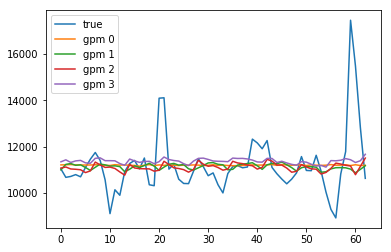

i =  248


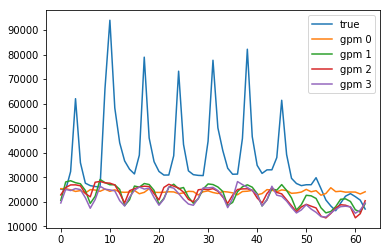

i =  407


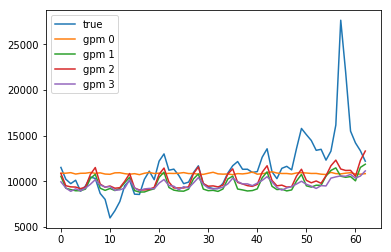

i =  445


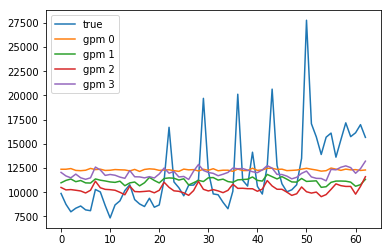

i =  699


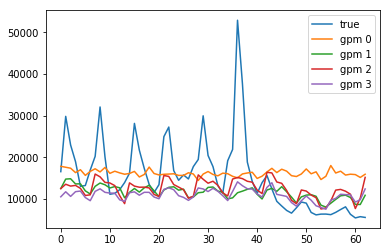

In [189]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

In [190]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

array([[  160,   248,   407,   445,   699],
       [37438, 38497, 40186, 40499, 75091]])

In [191]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

array([[ 11174.5 ,   2331.  ,   8139.5 ,  14540.75,    360.  ],
       [ 11150.75,  18771.75,  10364.  ,  11836.  ,  10268.5 ]], dtype=float32)

#### Group = 2

In [192]:
gp = 2
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [193]:
Y_list.shape

(4, 77416, 63)

In [194]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

array([27974, 31170, 49156, 62451, 75988])

In [195]:
output_log_std_p = [1.]

Group 2
i =  27974


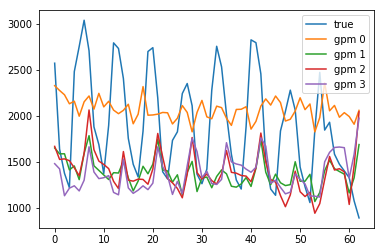

i =  31170


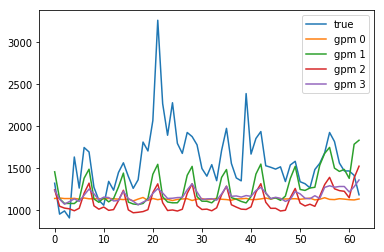

i =  49156


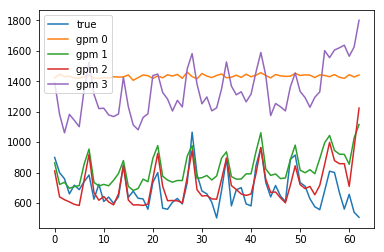

i =  62451


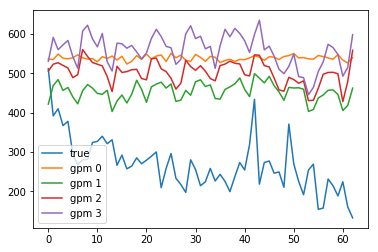

i =  75988


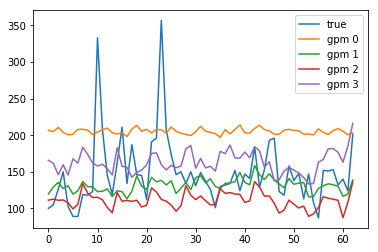

In [196]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

Group 2
i =  27974


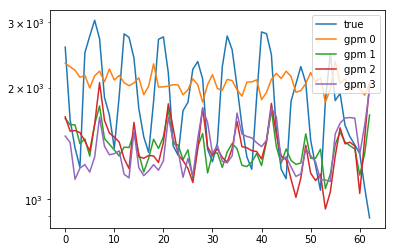

i =  31170


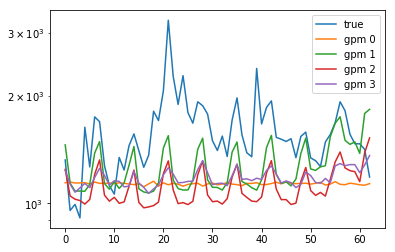

i =  49156


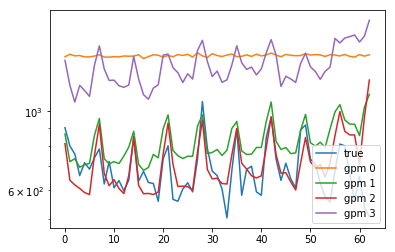

i =  62451


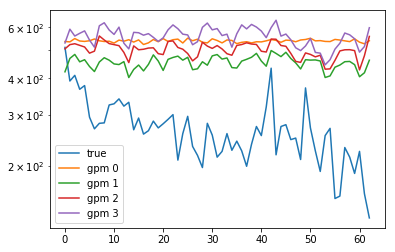

i =  75988


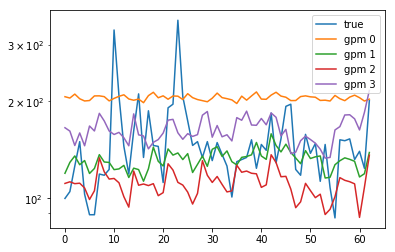

In [197]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.yscale('log')
    plt.legend(); plt.show()    

In [ ]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

In [ ]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

#### Case 131296

In [ ]:
i = 131296

In [ ]:
multi_view((Y_output_ori[i],Y_output_pred_ori[i]))

### Cases study

In [ ]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = examine_list_gp((Y_output_ori,
                             Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             ), output_gp, view_list=view_list)

i = 93175
plt.plot(Y_output_ori[i], label='true')
plt.plot(Y_output_pred_ori_ens_mean[i], label='ens mean')
plt.plot(Y_output_pred_ori_ens_med[i], label='ens median')
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.plot(Y_output_pred_ens_med_ori[i], label='ens median before transf')
plt.plot(Y_output_pred_ori_ens[-1][i], label='run: 4')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

i = 93175
plt.plot(Y_output_ori[i], label='true')
for run in ens_list:
    plt.plot(Y_output_pred_ori_ens[run][i], label='run' + str(run))
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

In [ ]:
view_list = examine_list_gp((Y_output_pred_ori_ens[-1], 
                             Y_output_pred_ori_ens_med,
                             Y_output_f_gpm, 
                             Y_output_ori), output_gp, view_list=view_list)

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

In [ ]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

In [ ]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

view_list_review = [score < model_smape for score in view_list_smape]; view_list_review

view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

#### Good cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

print(Y_output_center[view_list_good].reshape(-1))
print(Y_output_center[view_list_bad].reshape(-1))

print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

output_gp[view_list_good]

output_gp[view_list_bad]

#### Case 93175

i = 93175

multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

smape(Y_output_pred_ori[i], Y_output_raw[i])

Y_input_center[i], Y_output_center[i], input_scale[i], output_scale[i]

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

review_Y = np.array([score < model_smape for score in smape_Y_pred])
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; #good_Y_index
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; #bad_Y_index

good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

good_Y_input_center = Y_input_center[good_Y_index]
good_Y_output_center = Y_output_center[good_Y_index]
bad_Y_input_center = Y_input_center[bad_Y_index]
bad_Y_output_center = Y_output_center[bad_Y_index]

examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

good_output_scale.min(), good_output_scale.max()

bad_output_scale.min(), bad_output_scale.max()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

np.mean(good_output_scale), np.mean(good_input_scale)

np.mean(bad_output_scale), np.mean(bad_input_scale)

plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

plt.figure(figsize=(12,4))
plt.hist(good_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

### stdev/median

output_factor_1 = (Y_output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, Y_output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, Y_output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / Y_output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (Y_output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [ ]:
Y_output_dates

In [ ]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_f_omed, columns = Y_output_dates)  # using ensemble median combined result
result_df

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

In [ ]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

### Output DataFrame

In [ ]:
if test_length == 0:
    print('%%% Reading data key_1.csv ...', end = '', flush = True)
    output_df = pd.read_csv("../data/key_1.csv")
    print('done!')

In [ ]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

In [ ]:
output_df.info()

In [ ]:
output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

In [ ]:
Y_output_dates

In [ ]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

In [ ]:
del result_flat_df

In [ ]:
gc.collect()

In [ ]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [ ]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]